In [1]:
import os
import cv2
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog
from skimage import exposure

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
# Directorio de imágenes
image_dir = "billetes/"
labels = []
features = []

In [3]:
# Procesamiento de imágenes y extracción de características
for file in os.listdir(image_dir):
    if file.lower().endswith(".jpg"):
        match = re.search(r'MX(\d+)N', file)
        if match:
            label = int(match.group(1))
        else:
            print(f"No se pudo extraer la etiqueta de: {file}")
            continue
        
        img_path = os.path.join(image_dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        
        # HOG
        hog_features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)
        features.append(hog_features)
        labels.append(label)



In [4]:
# Convertir a numpy arrays
X = np.array(features)
Y = np.array(labels)

In [5]:
# Mostrar distribución de clases
unique, counts = np.unique(Y, return_counts=True)
print("Distribución de clases:")
for u, c in zip(unique, counts):
    print(f"Denominación {u}: {c} imágenes")

Distribución de clases:
Denominación 20: 75 imágenes
Denominación 50: 80 imágenes
Denominación 100: 80 imágenes
Denominación 200: 80 imágenes
Denominación 500: 80 imágenes


In [6]:
# División de datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
# Normalización de datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Búsqueda de mejores hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf'],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, Y_train)

print("Mejores parámetros encontrados:")
print(grid.best_params_)

Mejores parámetros encontrados:
{'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


In [9]:
# Entrenar el mejor modelo encontrado
modelo = grid.best_estimator_


In [10]:
# Guardar modelo y scaler
with open("modelo_completo.pkl", "wb") as f:
    pickle.dump({'modelo': modelo, 'scaler': scaler}, f)

In [11]:
# Cargar el modelo
with open("modelo_completo.pkl", "rb") as f:
    data = pickle.load(f)
    modelo = data['modelo']
    scaler = data['scaler']

In [12]:
# Evaluación del modelo
y_pred = modelo.predict(X_test)

cm = confusion_matrix(Y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

print("\nReporte de clasificación:")
print(classification_report(Y_test, y_pred))

Matriz de Confusión:
[[13  0  0  0  0]
 [ 0 16  0  0  0]
 [ 0  0 15  0  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0 19]]

Reporte de clasificación:
              precision    recall  f1-score   support

          20       1.00      1.00      1.00        13
          50       1.00      1.00      1.00        16
         100       1.00      1.00      1.00        15
         200       1.00      1.00      1.00        16
         500       1.00      1.00      1.00        19

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79



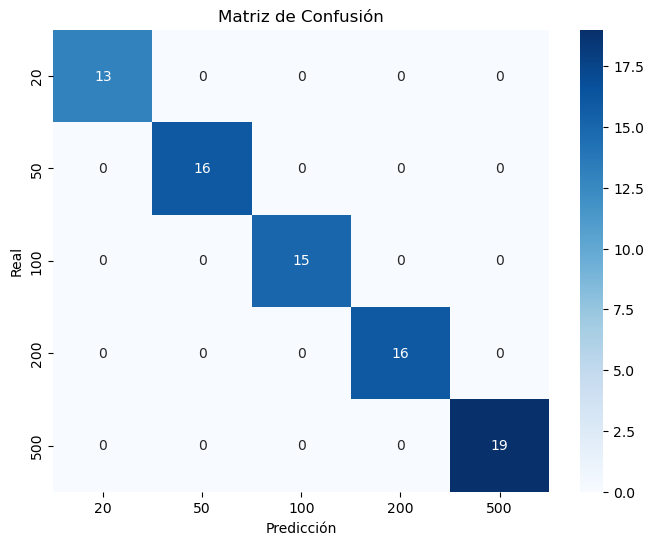

In [13]:
# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique, yticklabels=unique)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

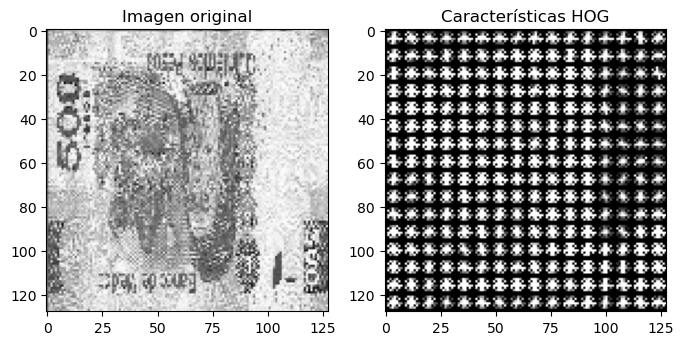

In [15]:
# Visualización de HOG (opcional)
sample_image_path = os.path.join(image_dir, os.listdir(image_dir)[0])
img = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (128, 128))
hog_features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(img_resized, cmap=plt.cm.gray)
plt.title('Imagen original')
plt.subplot(122)
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.title('Características HOG')
plt.show()